In [1]:
import os
import time
import numpy as np
import pickle
import torch
from torch.utils import data
from torch import nn, optim
from torch.nn import functional as F
from torchvision.models import resnet152
import matplotlib.pyplot as plt

from dataset import NyuV2

In [12]:
data_path = './data/nyu_v2/'
model_file = './models/resnet.pt'
batch_size = 4
# img_size = (224, 224)
depth_size = (25, 32)
# max_img_val = 255.0
# max_depth_val = 9.9955
nepochs = 1
seed = 2
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_loader = data.DataLoader(NyuV2(os.path.join(data_path, 'train')),
                               batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(NyuV2(os.path.join(data_path, 'test')),
                              batch_size=batch_size, shuffle=True)

In [14]:
model = resnet152(pretrained=True)
model.fc = nn.Linear(2048, depth_size[0] * depth_size[1])
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [5]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        depth_maps = model(data)
        loss = F.mse_loss(depth_maps, labels, reduction='sum')
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        if batch % 100 == 0:
            print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch * len(data), len(train_loader.dataset),
                100. * batch / len(train_loader),
                loss.item() / len(data)))
    
    return train_loss / len(train_loader.dataset)

In [6]:
for epoch in range(1, nepochs+1):
    epoch_start_time = time.time()
    avg_train_loss = train(epoch)
    print('====> Epoch: {} time: {:.1f}m Average loss: {:.4f} RMSE: {:.4f}'.format(
        epoch, (time.time() - epoch_start_time) / 60, avg_train_loss, avg_train_loss**0.5))

/anaconda/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Train epoch: 1 [0/1100 (0%)]	Loss: 137.698898
Train epoch: 1 [400/1100 (36%)]	Loss: 5.438540
Train epoch: 1 [800/1100 (73%)]	Loss: 7.104003
====> Epoch: 1 time: 2.3m Average loss: 13.5073 RMSE: 3.6752


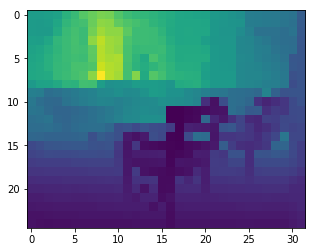

In [7]:
sample = next(iter(test_loader))
d = sample[1][0].view(depth_size)
plt.imshow(d)

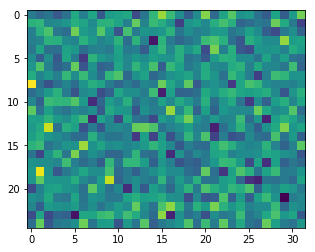

In [15]:
with torch.no_grad():
    depth_maps = model(sample[0].to(device))
d_hat = depth_maps[0].view(depth_size)
plt.imshow(d_hat.cpu().data.numpy())

In [13]:
torch.save(model.state_dict(), model_file)